In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms


def get_transforms(std=0.5, mean=0.5):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])
    
def cut_data(data, first_proportion=0.8):
    first_size = int(len(data) * first_proportion)
    second_size = len(data) - first_size
    first_data, second_data = torch.utils.data.random_split(data, [first_size, second_size])
    return first_data, second_data

def get_data_MNIST(std=0.5, mean=0.5, train_size=0.8):
    train_data = datasets.MNIST(root='data', train=True, transform=get_transforms(std, mean), download=True)
    test_data = datasets.MNIST(root='data', train=False, transform=get_transforms(std, mean), download=True)
    train_data, val_data = cut_data(train_data, train_size)
    return train_data, val_data, test_data

def get_data_CIFAR10(std=0.5, mean=0.5, train_size=0.8):
    train_data = datasets.CIFAR10(root='data', train=True, transform=get_transforms(std, mean), download=True)
    test_data = datasets.CIFAR10(root='data', train=False, transform=get_transforms(std, mean), download=True)
    train_data, val_data = cut_data(train_data, train_size)
    return train_data, val_data, test_data

def inspect(data):
    print(f"Data type: {type(data)}")
    print(f"Data length: {len(data)}")
    print(f"Data shape: {data[0][0].shape}")
    
def check_data(train_data, val_data, test_data):
    inspect(train_data)
    inspect(val_data)
    inspect(test_data)
    # Total de datos
    print(f"Total data: {len(train_data) + len(val_data) + len(test_data)}\n")

In [2]:
train_mnist, val_mnist, test_mnist = get_data_MNIST()
check_data(train_mnist, val_mnist, test_mnist)
train_cifar10, val_cifar10, test_cifar10 = get_data_CIFAR10()
check_data(train_cifar10, val_cifar10, test_cifar10)

Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 48000
Data shape: torch.Size([1, 28, 28])
Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 12000
Data shape: torch.Size([1, 28, 28])
Data type: <class 'torchvision.datasets.mnist.MNIST'>
Data length: 10000
Data shape: torch.Size([1, 28, 28])
Total data: 70000

Files already downloaded and verified
Files already downloaded and verified
Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 40000
Data shape: torch.Size([3, 32, 32])
Data type: <class 'torch.utils.data.dataset.Subset'>
Data length: 10000
Data shape: torch.Size([3, 32, 32])
Data type: <class 'torchvision.datasets.cifar.CIFAR10'>
Data length: 10000
Data shape: torch.Size([3, 32, 32])
Total data: 60000



In [3]:
# Plotear una imagen de ejemplo
def plot_image(data, index):
    image, label = data[index]
    fig = plt.figure(figsize=(5, 5))
    # Check rgb or grayscale
    if image.shape[0] == 1:
        image = image[0]
        plt.imshow(image, cmap='gray')
    else:
        image = image.permute(1, 2, 0)
        plt.imshow(image)
    plt.title(f"Label: {label}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


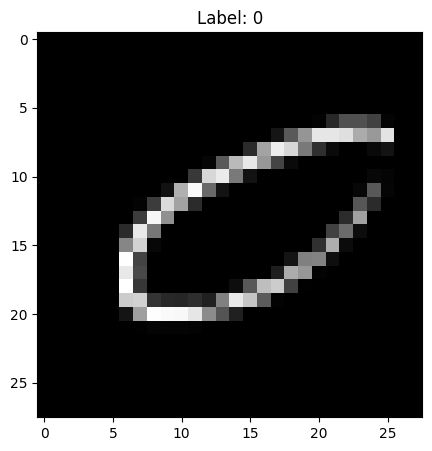

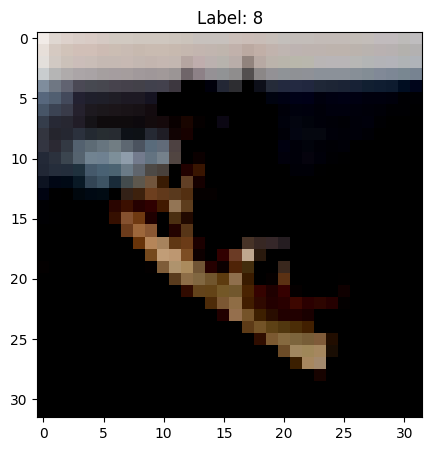

In [4]:
plot_image(train_mnist, 10)
plot_image(train_cifar10, 10) 

In [23]:
# Creamos una capa de convolución

class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ConvLayer, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.conv(x))
    
# Max Pooling + Batch Normalization + Dropout (opcional)
class MaxPoolBN(torch.nn.Module): 
    def __init__(self, in_channels, kernel_size = 2, stride=2, padding=0, dropout=0.1):
        super(MaxPoolBN, self).__init__()
        self.max_pool = torch.nn.MaxPool2d(kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(in_channels)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.bn(self.max_pool(x)))
    
# Capa densa + dropout (opcional)
class Dense(torch.nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1):
        super(Dense, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.linear(x))
    
# structure = [N, L1, k1, ..., Ln, kn], con L la cantidad de capas y k el kernel size
class ConvNet(torch.nn.Module):
    def __init__(self,in_channels, structure, size=28, classes=10):
        super(ConvNet, self).__init__()
        self.size = size
        self.structure = structure
        self.L = [structure[i] for i in range(len(structure)) if i % 2 == 1]
        self.k = [structure[i] for i in range(len(structure)) if i % 2 == 0 and i != 0]
        self.layers = torch.nn.ModuleList()
        for i in range(len(self.L)):
            if i == 0:
                self.layers.append(ConvLayer(in_channels, self.L[i], self.k[i]))
                self.layers.append(torch.nn.Dropout(0.1))
            else:
                self.layers.append(ConvLayer(self.L[i-1], self.L[i], self.k[i]))
                self.layers.append(torch.nn.Dropout(0.1))
                
            # Max pooling en cantidad par de capas 
            if i % 2 == 1:
                self.layers.append(MaxPoolBN(self.L[i], 2))
                self.size = self.size // 2
                
        # Caso impares
        if len(self.L) % 2 == 1:
            self.layers.append(MaxPoolBN(self.L[-1], 2))
            self.size = self.size // 2
            
        # Cabeza clasificadora
        self.layers.append(torch.nn.Flatten())
        self.layers.append(Dense(self.L[-1] * self.size * self.size, 128))
        self.layers.append(torch.nn.Dropout(0.5))
        self.layers.append(Dense(128, classes))
                
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
# Profundidad de CIFAR10 (32/2^4 = 2 -> 4x2 capas convolucionales maximo) depth in [2,8]
# E:32 --c1--> 32 --c2--> 32 --MP-->
# 16 --c3--> 16 --c4--> 16 --MP-->
# 8 --c5--> 8 --c6--> 8 --MP-->
# 4 --c7--> 4 --c8--> 4 --MP--> 2 

In [24]:
# Probar con un batch de entrada 1 x 1 x 28 x 28
# Cargamos el dataset de CIFAR10
train_data, val_data, test_data = get_data_CIFAR10()

Files already downloaded and verified
Files already downloaded and verified


In [25]:
# Creamos el modelo
L = [64, 64, 128, 128, 128, 128, 64, 64]
k = [ 3,  3,   3,   3,   3,   3,  3,  3]
structure = [item for sublist in [[L[i], k[i]] for i in range(len(L)) ] for item in sublist]
structure = [len(structure)//2] + structure

# Obtener un ejemplo de entrada
x, y = train_data[0]
x = x.unsqueeze(0)
print(f"Input shape: {x.shape}")

# Creamos el modelo
model = ConvNet(3, structure, size=32, classes=10)
print(model)

Input shape: torch.Size([1, 3, 32, 32])
ConvNet(
  (layers): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (1): Dropout(p=0.1, inplace=False)
    (2): ConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPoolBN(
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (5): ConvLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (6): Dropout(p=0.1, inplace=False)
    (7): ConvLayer(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (8): Dropout(p=0.1, inplace=False)
   

In [26]:
structure

[8, 64, 3, 64, 3, 128, 3, 128, 3, 128, 3, 128, 3, 64, 3, 64, 3]

In [27]:
# Probamos el modelo
y_pred = model(x)

In [28]:
def run_epoch(model, data_loader, criterion, optimizer, device, train=True):
    if train:
        model.train()
    else:
        model.eval()
    
    loss_total = 0
    acc_total = 0
    for x, y in data_loader:
        # Enviamos los datos al dispositivo
        x = x.to(device)
        y = y.to(device)
        # Forward
        with torch.set_grad_enabled(train):
            y_pred = model(x)
            loss = criterion(y_pred, y)
        # Backward
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Acumulamos los resultados
        loss_total += loss.item() * x.size(0)
        acc_total += (y_pred.argmax(1) == y).sum().item()
    # Promediamos los resultados
    loss_total /= len(data_loader.dataset)
    acc_total /= len(data_loader.dataset)
    return loss_total, acc_total

def train_epoch(model, train_loader, val_loader, criterion, optimizer, device):
    train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, train=True)
    val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer, device, train=False)
    return train_loss, train_acc, val_loss, val_acc

# Entrenar un modelo
def train(model, train_data, val_data, epochs=100, batch_size=256, lr=0.001, device='cpu', folder='models'):
    # Definimos el optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Definimos la función de costo
    criterion = torch.nn.CrossEntropyLoss()
    # Enviamos el modelo al dispositivo
    model.to(device)
    # Definimos los dataloaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    # Definimos las listas para guardar los resultados
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    # Early stopping
    epochs_without_improvement = 0
    # Entrenamos
    for epoch in range(epochs):
        # Entrenamos un epoch
        train_loss, train_acc, val_loss, val_acc = train_epoch(model, train_loader, val_loader, criterion, optimizer, device)
        # Guardamos los resultados
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # Si mejora el resultado, guardamos el modelo
        best_val_loss = np.min(val_losses)
        if val_loss > best_val_loss:
            torch.save(model.state_dict(), f"{folder}/model.pth")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        # Si no mejora el resultado durante 10 epochs, detenemos el entrenamiento
        if epochs_without_improvement == 10:
            print(f"Training stopped at epoch {epoch+1}")
            break
        # Imprimimos los resultados
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train loss: {train_loss:.4f} - Train acc: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f} - Val acc: {val_acc:.4f}")
    return train_losses, train_accuracies, val_losses, val_accuracies

In [30]:
# Entrenamos el modelo
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_data, val_data, epochs=1, batch_size=256, lr=0.001, device='cuda')

Epoch 1/1:
Train loss: 1.2344 - Train acc: 0.5638
Val loss: 1.0213 - Val acc: 0.6342


Algorithm 1 Proposed Genetic Algorithm
Input: (max_gen, cross_prob, mutation_prob,
max_pop, conv_parameters)
Output: elite


1: generation ← 0

2: population ← Generate initial population from Input parameters.

3: while generation < max_gen do

4: for individual in population do

5: individual.accuracy ← obtain validation accuracy value from training network defined by individual’s cromosome and conv_parameters

6: end for

7: Calculate each individual fitness from population

8: elite ← Get individual with best fitness from population

9: children_list ← Empty list

10: next_pop ← Empty list

11: for individuals in population do

12: if Random([0,1]) ≤cross_prob then

13: Choose parent1 and parent2 from population using proportional roulette wheel selection.

14: if generation/max_gen < Random([0,1]) then

15: child1, child2 ← Cross parent1 and parent2 sequentially

16: else

17: child1, child2 ← Cross parent1 and parent2 with binary list

18: end if

19: Add child1 and child2 to children_list

20: end if

21: if generation < max_gen/2 then

22: next_pop ← apply mutation to children_list with probability mutation_prob

23: else

24: survivors ← Select a fraction of survivors from population, according to fitness

25: Add survivors, children_list and elite to next_pop

26: next_pop ← apply mutation to next_pop with probability mutation_prob

27: end if

28: Fill next_pop with random individuals or delete random individuals until max_pop total individuals

29: if elite not in next_pop then

30: Replace random individual from next_pop with elite

31: end if

32: population ← next_population

33: generation ← generation +1

34: end for

35: end while

36: Train population and return the elite

In [ ]:
def cromosome_to_model(cromosome):
    # Creamos el modelo
    model = ConvNet(3, cromosome, size=32, classes=10)
    return model

def mutate_cromosome(cromosome, depths, filters, kernel_sizes):
    # Rand 0.5
    if np.random.rand() < 0.5:
        current_depth = cromosome[0]
        # Mutamos la cantidad de capas eligiendo un valor al azar del vector depths
        new_depth = np.random.choice(depths)
        if new_depth > current_depth:
            for i in range(new_depth - current_depth): 
                cromosome.insert(1, np.random.choice(filters))
                cromosome.insert(2, np.random.choice(kernel_sizes))
                
        elif new_depth < current_depth:
            for i in range(current_depth - new_depth):
                # Eliminamos el filtro y el kernel size
                cromosome.pop(1)
                cromosome.pop(1)
                
    else: # Rand 0.5
        # Mutamos una posición al azar que no sea la primera
        pos = np.random.randint(1, len(cromosome))
        # Si es impar, mutamos el filtro, si es par, mutamos el kernel size
        cromosome[pos] = np.random.choice(filters) if pos % 2 == 1 else np.random.choice(kernel_sizes)
    
    return cromosome

def sequential_crossover(cromosome1, cromosome2):
    # Elegimos un punto de corte al azar
    pos = np.random.randint(2, len(min(cromosome1[1:], cromosome2[1:]))//2 + 1)
    # Realizamos el crossover
    new_cromosome1 = cromosome1[:2*pos+1] + cromosome2[2*pos+1:]
    new_cromosome2 = cromosome2[:2*pos+1] + cromosome1[2*pos+1:]
    # Actualizamos la profundidad
    new_cromosome1[0] = len(new_cromosome1[1:])//2
    new_cromosome2[0] = len(new_cromosome2[1:])//2
    return new_cromosome1, new_cromosome2

def binary_crossover(cromosome1, cromosome2):
    # Lista binaria de len(cromosome)-1
    binary_list = [np.random.randint(0, 2) for _ in range(len(min(cromosome1[1:], cromosome2[1:])))]
    # Realizamos el crossover
    for i in range(len(binary_list)):
        if binary_list[i] == 1:
            cromosome1[i+1], cromosome2[i+1] = cromosome2[i+1], cromosome1[i+1]
    return cromosome1, cromosome2

def crossover(cromosome1, cromosome2, seq_prob=0.6): # seq prob = #gen/#total gen
    # Elegimos el tipo de crossover
    if np.random.rand() < seq_prob:
        return sequential_crossover(cromosome1, cromosome2)
    else:
        return binary_crossover(cromosome1, cromosome2)

def evaluate_cromosome(cromosome, train_data, val_data, epochs=100, batch_size=256, lr=0.001, device='cpu', folder='models'):
    # Creamos el modelo
    model = cromosome_to_model(cromosome)
    # Entrenamos el modelo
    train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_data, val_data, epochs=epochs, batch_size=batch_size, lr=lr, device=device, folder=folder)
    # Obtenemos el mejor modelo
    model.load_state_dict(torch.load(f"{folder}/model.pth"))
    # Evaluamos el modelo
    test_loss, test_acc = run_epoch(model, test_data, torch.nn.CrossEntropyLoss(), None, device, train=False)
    return test_loss, test_acc